In [1]:
#!/usr/bin/env python
# import analyzer
import importlib
from importlib import reload
import os, sys, glob, warnings, glob
import scipy
import numpy as np
import scipy as sp
import joblib
# from tqdm.notebook import tqdm
from tqdm import tqdm
import ROOT as root

import matplotlib.pyplot as plt
from matplotlib import collections, colors, transforms
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %matplotlib widget

Welcome to JupyROOT 6.22/00


In [2]:
# modules in this directory
import visualization, util, event, cutflow, detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(detector)
import visualization as vis

/cvmfs/cdms.opensciencegrid.org/releases/centos7/V04-07/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.19.5 is currently installed but you installed root_numpy against numpy 1.18.2. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)



RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [3]:
import lsfit
reload(lsfit)
from lsfit import *

import include_modules_root as rt
import Kalman_tom

# Intro

This notebook trys to develope a new seeding algorithm.

In [5]:
# data_dir    = "/project/def-mdiamond/tomren/mathusla/data/fit_study"
# files=glob.glob(f"{data_dir}/muon_1000_GeV_manual/*/*/stat*.root",)
# print(files)
# file_prefix='/project/def-mdiamond/tomren/mathusla/data/fit_study/muon_1000_GeV_manual/20230222/151935/'

# First, find out events with shared energy
file_prefix="."
filename=f"{file_prefix}/stat_seedmod.root"
tree_name="integral_tree"

In [6]:
ev = event.Event(filename, 0, tree_name=tree_name)
nevents = int(ev.Tree.GetEntries())   

results_fit = joblib.load("fit_result.joblib")
mask_7hits = results_fit["mask_7hits"]
mask_noshare = results_fit["mask_noshare"]
mask_temp = results_fit["mask_sidelobe"]
inds_1 = results_fit["sidelobe_inds"]
inds_actual = np.flatnonzero(mask_temp)

1317 452.23285829342905 447.21607325408934


/sdf/home/t/tomren/mathusla/mathusla_tracker_debugging/lsfit.py:103: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


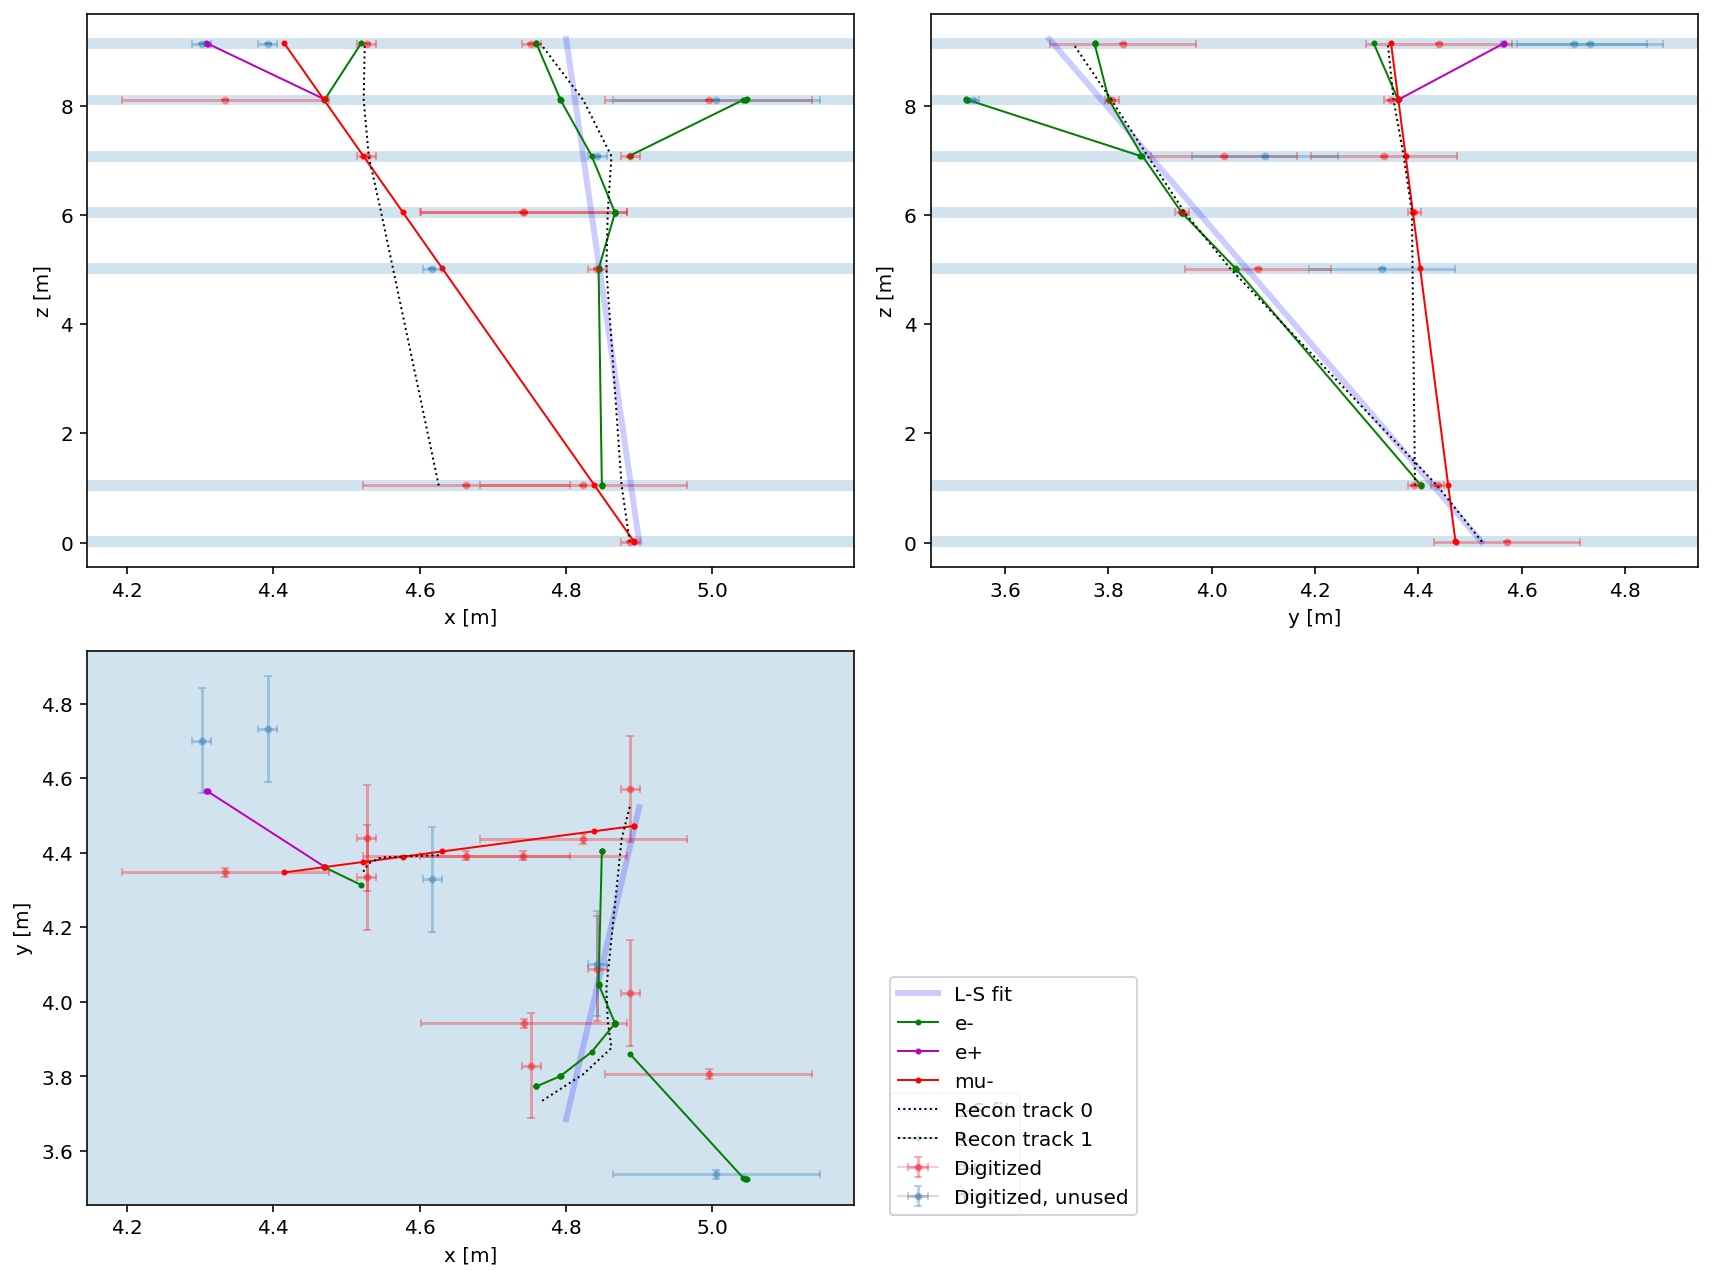

In [7]:
MAKE_PLOTS=True
PLOT_MAX=150
nplots=0


for idx,i_event in enumerate(inds_1[:PLOT_MAX]):
#     for i_event in range(200):
    if idx!=14:
        continue
    ev.EventNumber=i_event
    ev.Tree.GetEntry(i_event)

    hits = get_digi_hits(ev)
    nhits=len(ev.Tree.Hit_x)
    
    print(i_event,results_fit["par_fit"][inds_actual[idx],0],results_fit["par_truth"][inds_actual[idx],0])

    # Use Try to only process events with kalman reconstruction
    try:
        digi_hit_inds = util.unzip(ev.Tree.Track_k_m_hitIndices)
        digi_hit_len = np.array([len(i) for i in digi_hit_inds])
        track_ind = int(np.argmax(digi_hit_len==7))
        track_hits_inds=digi_hit_inds[track_ind]   
        hits_fit=np.array(hits)[track_hits_inds]

        par_km =[ev.Tree.Track_k_m_x0[track_ind], ev.Tree.Track_k_m_y0[track_ind], ev.Tree.Track_k_m_z0[track_ind], ev.Tree.Track_k_m_t0[track_ind], ev.Tree.Track_k_m_velX[track_ind], ev.Tree.Track_k_m_velY[track_ind], ev.Tree.Track_k_m_velZ[track_ind]]
        par_km_error =[ev.Tree.Track_k_m_ErrorX0[track_ind], ev.Tree.Track_k_m_ErrorY0[track_ind], ev.Tree.Track_k_m_ErrorZ0[track_ind], ev.Tree.Track_k_m_ErrorT0[track_ind], ev.Tree.Track_k_m_ErrorVx[track_ind], ev.Tree.Track_k_m_ErrorVy[track_ind], ev.Tree.Track_k_m_ErrorVz[track_ind]]
        xyz0_km = util.coord_cms2det(np.array(par_km[:3]))
        xyzV_km = np.array([par_km_error[2+4],par_km_error[0+4],-par_km_error[1+4]])

    except:
        continue


    # Do LS fit
    guess=guess_track(hits_fit)
    fit1=fit_track(hits_fit,guess)
    par_fit=list(fit1.values)
    par_fit_error=list(fit1.errors)
    xyz0_fit = util.coord_cms2det(np.array(par_fit[:3]))
    xyzV_fit = np.array([par_fit[2+4],par_fit[0+4],par_fit[1+4]])
    time_seq=np.linspace(0,np.max(ev.Tree.Digi_time)-ev.Tree.Hit_time[0],100)


    # Get Truth value
    Tree=ev.Tree
    dt=Tree.Hit_time[1]-Tree.Hit_time[0]
    vx=(Tree.Hit_x[1]-Tree.Hit_x[0])/dt
    vy=(Tree.Hit_y[1]-Tree.Hit_y[0])/dt
    vz=(Tree.Hit_z[1]-Tree.Hit_z[0])/dt
    hit_x = np.array([ev.Tree.Hit_x[i] for i in range(nhits)])
    hit_y = np.array([ev.Tree.Hit_y[i] for i in range(nhits)])
    hit_z = np.array([ev.Tree.Hit_z[i] for i in range(nhits)])
    hit_e= np.array([ev.Tree.Hit_energy[i] for i in range(nhits)])
    hit_layer = np.array([cut.in_layer(i) for i in hit_y])

    # Use the energy-weighted average on layer 3 (first tracker layer) as position truth
    hits_truth_e = hit_e[hit_layer==3]
    hits_truth_x = np.sum(hit_x[hit_layer==3]*hits_truth_e)/np.sum(hits_truth_e)     
    hits_truth_y = np.sum(hit_y[hit_layer==3]*hits_truth_e)/np.sum(hits_truth_e)     
    hits_truth_z = np.sum(hit_z[hit_layer==3]*hits_truth_e)/np.sum(hits_truth_e)     

    # par_truth = [Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_z[0], Tree.Hit_time[0],vx,vy,vz]
    par_truth = [hits_truth_x, hits_truth_y, hits_truth_z, Tree.Hit_time[0],vx,vy,vz]
    xyz0_truth = util.coord_cms2det(np.array([Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_z[0]]))


    # Make plots
    if MAKE_PLOTS and nplots<PLOT_MAX:
        nplots+=1

        # Plot truth+recon
        fig,axs=plt.subplots(2,2,figsize=(12,9))
        # fig = vis.plot_truth(ev,fig=fig, disp_det_view=False, disp_vertex=False, disp_first_hit=False);
        axs=axs.flatten()
        axs[0].plot(xyz0_fit[0]+xyzV_fit[0]*time_seq/100, 
                         xyz0_fit[2]+xyzV_fit[2]*time_seq/100, 
                         color="b",alpha=0.2,linewidth=3,label="L-S fit")  
        axs[1].plot(xyz0_fit[1]+xyzV_fit[1]*time_seq/100, 
                         xyz0_fit[2]+xyzV_fit[2]*time_seq/100, 
                         color="b",alpha=0.2,linewidth=3,label="L-S fit")    
        axs[2].plot(xyz0_fit[0]+xyzV_fit[0]*time_seq/100, 
                         xyz0_fit[1]+xyzV_fit[1]*time_seq/100, 
                         color="b",alpha=0.2,linewidth=3,label="L-S fit")                  
        
        fig = vis.plot_truth(ev,fig=fig, disp_det_view=False, disp_vertex=False, disp_first_hit=False);
        fig = vis.plot_recon(ev,fig=fig, disp_det_view=True, disp_recon_vertex=False);
        plt.show()

                


## New seeding algorithm

In [8]:
reload(Kalman_tom)

<module 'Kalman_tom' from '/sdf/home/t/tomren/mathusla/mathusla_tracker_debugging/Kalman_tom.py'>

In [23]:
class kf_find():
    def __init__(self,seed, hits, seed0_idx,  hits_used_mask=None, chi2_add=20, chi2_pval_drop=0.99):
        self.seed = np.array(seed)
        self.hits = np.array(hits)
        
        # Setup a Kalman filter 
        self.X0,self.P0 = self.init_state(seed)
        self.M0=self.X0[:3]
        # Initial Measurement Matrix: M = HX + z, project from state vector to measurement
        self.H = np.array(\
            [[1,0,0,0,0,0],
             [0,1,0,0,0,0],
             [0,0,1,0,0,0]])
        # Initial propogation covariacne (Q)
        self.Q=0        
        # Kalman Filter Object
        self.kf = Kalman_tom.KalmanFilter(self.X0,self.P0,self.M0, H=self.H)
        
        # Get info of hits
        self.hits_layer = np.array([cut.in_layer(hit.y) for hit in hits])
        self.hits_time = np.array([hit.t for hit in hits])
        self.seeds_layer = np.array([cut.in_layer(hit.y) for hit in seed])
        self.seeds_time = np.array([hit.t for hit in seed])        
        self.UP=True
        self.DOWN=False
        self.seed_direction = self.UP if (self.seeds_layer[1]-self.seeds_layer[0])/(self.seeds_time[1]-self.seeds_time[0])>0 else self.DOWN
        self.seed0_idx = seed0_idx
        self.seed0_layer = self.hits_layer[seed0_idx]
        
        if hits_used_mask is None:
            hits_used_mask=np.zeros(len(hits),dtype=bool)
        self.hits_used_mask=hits_used_mask
            
        # Other status variables
        self.TOP_LAYER = np.max(self.hits_layer)
        self.BOTTOM_LAYER = np.min(self.hits_layer)
        self.CURREN_LAYER = 0;
        self.MINIMUM_HITS = 4;
        self.FOUND_HITS_IDX = [seed0_idx];        
        self.SUCCEED = False;
        self.chi2_add = chi2_add
        
        
    
    def init_state(self, hits):
        i=0;        j=1;
        dt=hits[j].t-hits[i].t
        dx=hits[j].x-hits[i].x
        dy=hits[j].y-hits[i].y
        dz=hits[j].z-hits[i].z

        # Initial State Vector: X0
        X0 = np.array([hits[0].x, hits[0].t, hits[0].z, dx/dt, dy/dt, dz/dt])

        # Initial Variance P0
        J =np.array([[ 1      , 0           , 0       , 0       , 0       , 0             , 0     , 0     ],
            [ 0       , 1           , 0       , 0       , 0       , 0             , 0     , 0     ],
            [ 0       , 0           , 1       , 0       , 0       , 0             , 0     , 0     ],
            [- 1 / dt, dx / (dt*dt), 0       , 0       , 1 / dt  , - dx / (dt*dt), 0     , 0     ],
            [0       , dy / (dt*dt), 0       , - 1 / dt, 0       , - dy / (dt*dt), 0     , 1 / dt],
            [0       , dz / (dt*dt), - 1 / dt, 0       , 0       , - dz / (dt*dt), 1 / dt, 0     ]])
        # Initial Variance P0
        err0=np.diag([hits[i].x_uncertainty,hits[i].t_uncertainty,hits[i].z_uncertainty,hits[i].y_uncertainty,
                     hits[j].x_uncertainty,hits[j].t_uncertainty,hits[j].z_uncertainty,hits[j].y_uncertainty])**2
        P0=J.dot(err0).dot(J.T)

        return X0, P0


    def add_measurement(self, hit, X_current, dy):
        vy_current = X_current[4]
        dt_next = dy/vy_current
        Y = np.array([hit.x,hit.t,hit.z])
        R = np.diag([hit.x_uncertainty,hit.t_uncertainty,hit.z_uncertainty])**2
        A = np.array([[1, 0, 0, dt_next, 0, 0],
                      [0, 1, 0, 0, dt_next/vy_current, 0],
                      [0, 0, 1, 0, 0, dt_next],
                      [0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 0, 1]])
        return  Y,R,A
    
    def add_measurement_corrected(self, hit, X_current, dy):
        """
        Change the definition of A to the jacobian of f
        return f as well
        """
        vx_current = X_current[3]
        vy_current = X_current[4]
        vz_current = X_current[5]
        dt_next = dy/vy_current
        Y = np.array([hit.x,hit.t,hit.z])
        R = np.diag([hit.x_uncertainty,hit.t_uncertainty,hit.z_uncertainty])**2
        A = np.array([[1, 0, 0, dt_next, -dy*vx_current/vy_current**2, 0],
                      [0, 1, 0, 0, -dt_next/vy_current, 0],
                      [0, 0, 1, 0, -dy*vz_current/vy_current**2, dt_next],
                      [0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 0, 1]])
        f = lambda state: f_model(*state, dy)
        return  Y,R,A, f
    
    def undo_kf_step(self, kf):
        del kf.X_predicted[-1]
        del kf.A_s[-1]
        del kf.Q_s[-1]
        del kf.P_predicted[-1]
        del kf.X_filtered[-1]
        del kf.P_filtered[-1]
        del kf.K_s[-1]
        del kf.M_measurements[-1]
        return
    
    
    def find_all(self):
        y_pre = self.seed[0].y
        
        # For each layer, pick one hit that matches the seed the best
        chi2_forward=[]
        for layer in np.arange(self.BOTTOM_LAYER, self.TOP_LAYER+1):
            # Bypass the layer of the seed
            if layer==self.seed0_layer:
                continue
            
            # Examine the chi2 by trying to add each hit to the KF
            mask_hit = ~self.hits_used_mask & (self.hits_layer==layer)
            if sum(mask_hit)==0: # continue if there is no hits on this layer
                continue
            hits_in_use = self.hits[mask_hit]
            hits_in_use_idx = np.arange(len(hits))[mask_hit]
            chi2_list = []
            for hit in hits_in_use:
                # Add hit and filter
                dy = hit.y-y_pre
                X_previous = self.kf.X_filtered[-1]
                M_current,R,A,f = self.add_measurement_corrected(hit, X_previous, dy)
                X_predicted, P_predicted = self.kf.predict_foward(A,self.Q,f=f)# self.kf.predict_foward(A,self.Q)
                X_filtered, P_filtered = self.kf.filter_forward(M_current,R)

                # calculate the increment in the chi squared
                Y = [hit.x, hit.t, hit.z]
                H = self.H
                err_metric_p = R + H @ P_filtered @ H.transpose();
                chi_plus = (Y - H@X_filtered).transpose() @ np.linalg.inv(err_metric_p) @ (Y - H @ X_filtered);
                chi2_list.append(chi_plus)
                
                # Revert the KF by one step
                self.undo_kf_step(self.kf)
                
            #print(layer,chi2_list)

            # add the hit if chi2 is smaller than the threshold
            if np.min(chi2_list)<self.chi2_add:
                # add the good hit back to KF
                hit = hits_in_use[np.argmin(chi2_list)]
                dy = hit.y-y_pre
                X_previous = self.kf.X_filtered[-1]
                M_current,R,A,f = self.add_measurement_corrected(hit, X_previous, dy)
                X_predicted, P_predicted = self.kf.predict_foward(A,self.Q,f=f)# self.kf.predict_foward(A,self.Q)
                self.kf.filter_forward(M_current,R)  
                
                # add hit to USED list
                self.FOUND_HITS_IDX.append(hits_in_use_idx[np.argmin(chi2_list)])
                
                # Update the Y_PRE
                y_pre = hit.y
                
                # Update chi2
                chi2_forward.append(np.min(chi2_list))
                
                # print(layer,self.FOUND_HITS_IDX)
#                 print(self.kf.X_filtered)
            else:
                continue
                    
        # Run the filter on all found hits again
        # , and do backward smoothing to drop bad hit    
        self.SUCCEED2 = True
        if len(self.FOUND_HITS_IDX)>=self.MINIMUM_HITS:
            dropping_mask=np.zeros(len(self.FOUND_HITS_IDX),dtype=bool)
            
            # Forward
            hits_filter = hits[self.FOUND_HITS_IDX]
            # --- need a new initial state X0 using the first and last hit:
            X0_new, P0_new = self.init_state(hits_filter[[0,-1]])
            M0_new = X0_new[:3]
            hit=hits_filter[0]
            R0_new = np.diag([hit.x_uncertainty,hit.t_uncertainty,hit.z_uncertainty])**2
            self.kf2 = Kalman_tom.KalmanFilter(X0_new,P0_new,M0_new, H=self.H, R0=R0_new)
            # Filter forward
            for i in range(1,len(self.FOUND_HITS_IDX)):
                hit = hits[i]
                dy = hits[i].y-hits[i-1].y
                X_previous = self.kf2.X_filtered[-1]
                M_current,R,A,f = self.add_measurement_corrected(hit, X_previous, dy)
                X_predicted, P_predicted = self.kf2.predict_foward(A,self.Q,f=f)# self.kf.predict_foward(A,self.Q)
                X_filtered, P_filtered = self.kf2.filter_forward(M_current,R)   
                # calculate the increment in the chi squared
                Y = [hit.x, hit.t, hit.z]
                H = self.H
                err_metric_p = R + H @ P_filtered @ H.transpose();
                chi_plus = (Y - H@X_filtered).transpose() @ np.linalg.inv(err_metric_p) @ (Y - H @ X_filtered);
                print("chi+",chi_plus)
                if chi_plus>self.chi2_add:
                    self.SUCCEED2 = False
            
            # Backward
            self.kf2._init_smooth()
            while self.kf2.CURRENT_STEP>=0:
                Y = self.kf2.M_measurements[self.kf2.CURRENT_STEP]
                R = self.kf2.R_s[self.kf2.CURRENT_STEP]
                # Run smoothing
                X_smoothed, P_smoothed = self.kf2._smooth_step()
                # Calculate chi2
                H = self.H
                X_smoothed = self.kf2.X_smoothed[0]
                P_smoothed = self.kf2.P_smoothed[0]
                chi_plus_s = (Y - H @ X_smoothed).transpose() @ np.abs(np.linalg.inv((R - H @ P_smoothed @ H.transpose()))) @ (Y - H @ X_smoothed)
                print(chi_plus_s)
                
                
            
        if len(self.FOUND_HITS_IDX)>=self.MINIMUM_HITS and self.SUCCEED2:
            self.SUCCEED = True
        else:
            self.SUCCEED = False
        
        return self.SUCCEED


In [24]:
def sort_hits(hits):
    times = []
    for hit in hits:
        times.append(hit.t)
    hits_sorted = np.array(hits)[np.argsort(times)]
    return hits_sorted

def seed_bilayer(hits, hits_used_mask):
    hits_inds = np.arange(len(hits))
    hits_layer = np.array([cut.in_layer(hit.y) for hit in hits])
    hits_layer_unused = np.unique(hits_layer[~hits_used_mask])
    
    hits_layer_pairs = []
    seeds = []
    seeds01_idx = []
    seeds_dy = []
    seeds_time0 = []
    
    # find layers with the same kind of directions
    for i in range(len(hits_layer_unused)):
        for j in range(i+1, len(hits_layer_unused)):
            if i%2!=j%2:
                hits_layer_pairs.append([hits_layer_unused[i], hits_layer_unused[j]])
    
    # Find all pairs of hits from the two layers
    for layer_pair in hits_layer_pairs:
        for i_hit0 in np.flatnonzero((hits_layer==layer_pair[0])&~hits_used_mask):
            for i_hit1 in np.flatnonzero((hits_layer==layer_pair[1])&~hits_used_mask):
                hit0 = hits[i_hit0]
                hit1 = hits[i_hit1]
                if hit0.t<hit1.t:
                    seeds.append([hit0, hit1])
                    seeds01_idx.append([i_hit0,i_hit1])
                    seeds_time0.append(hit0.t)
                else:
                    seeds.append([hit1, hit0])
                    seeds01_idx.append([i_hit1,i_hit0])
                    seeds_time0.append(hit1.t)
                seeds_dy.append(np.abs(hit1.y - hit0.y))
                    
    # Sort hits based on dy. Larger dy--> better accuracy
    # For each dy, sort by time. The one comes earlier has higher priority
    seeds_dy_unique = np.sort(np.unique(seeds_dy))[::-1]
    seeds_time0=np.array(seeds_time0)
    seeds=np.array(seeds)
    seeds01_idx=np.array(seeds01_idx)
    
    seeds_sorted=[]
    seeds01_idx_sorted=[]
    for dy in seeds_dy_unique:
        mask = seeds_dy==dy
        seeds_time0_sub = seeds_time0[mask]
        seeds_sub = seeds[mask][np.argsort(seeds_time0_sub)]
        seeds01_idx_sub = seeds01_idx[mask][np.argsort(seeds_time0_sub)]
        for i in range(len(seeds_sub)):
            seeds_sorted.append(seeds_sub[i])
            seeds01_idx_sorted.append(seeds01_idx_sub[i])
        
#     seeds = np.array(seeds)[np.argsort(seeds_dy)[::-1]]
#     seeds0_idx = np.array(seeds0_idx)[np.argsort(seeds_dy)[::-1]]
    
    return np.array(seeds_sorted), np.array(seeds01_idx_sorted)

In [25]:
# for hit in hits:
#     print(hit.y, hit.t)

In [27]:
def f_model(x,t,z,vx,vy,vz, dy):
    xn = x + dy*vx/vy
    tn = t + dy* 1/vy
    zn = z + dy*vz/vy
    return (xn, tn, zn, vx, vy, vz)

In [28]:
ii = 15
ii+=1
i_event=inds_1[ii]
ev.EventNumber=i_event
ev.Tree.GetEntry(i_event)
hits = np.array(get_digi_hits(ev))


# seed=[hits[0], hits[5]]
# hits_used_mask = np.zeros(len(hits),dtype=bool)
# u_kf_find = kf_find(seed,hits,0, chi2_add=19)
# u_kf_find.find_all()
# print(u_kf_find.FOUND_HITS_IDX)

tracks_found = []
seeds_found = []

hits_used_mask = np.zeros(len(hits),dtype=bool)
niter=0
while (sum(hits_used_mask)<len(hits_used_mask)):
#     print(hits_used_mask)
    seeds, seeds01_idx =  seed_bilayer(hits, hits_used_mask)
#     print(seeds01_idx)
    ALL_SEEDS_FAILED = True
    for i in range(len(seeds)):
        seed = seeds[i]
        seed0_idx = seeds01_idx[i][0]
        u_kf_find = kf_find(seed,hits,seed0_idx, hits_used_mask=hits_used_mask, chi2_add=10)
        # If a seed gives successful result, mask those hits
        #  - and break from the loop. Renew the seeds and come back
        if(u_kf_find.find_all()):
            print("Iteration",niter,", seed idx", seeds01_idx[i])
            print(u_kf_find.FOUND_HITS_IDX,"\n")
            hits_used_mask[u_kf_find.FOUND_HITS_IDX] = True
            ALL_SEEDS_FAILED = False
            # Store the found track
            tracks_found.append(hits[u_kf_find.FOUND_HITS_IDX])
            seeds_found.append(hits[seeds01_idx[i]])
            break
            
    # End the while loop if all seeds failed
    if ALL_SEEDS_FAILED:
        break
    
    # End the while loop if too many iterations
    niter+=1
    if niter>20:
        break

chi+ 0.7093220656056427
chi+ 1.2407039968361138
chi+ 0.8372994804935799
chi+ 0.5218493913633355
chi+ 2.11978632277868
chi+ 1.3604552265359782
5.143389237750999
0.5334629832485658
1.5112929572430815
1.4958150701337034
1.8030674932637898
3.0643915802288
Iteration 0 , seed idx [0 5]
[0, 9, 2, 3, 4, 5, 6] 

chi+ 2.8573546026789516
chi+ 2.9619949194948694
chi+ 2.5144703584909105
3.662120212850916
4.71634628754712
7.714827941338039
Iteration 1 , seed idx [1 7]
[1, 10, 7, 8] 



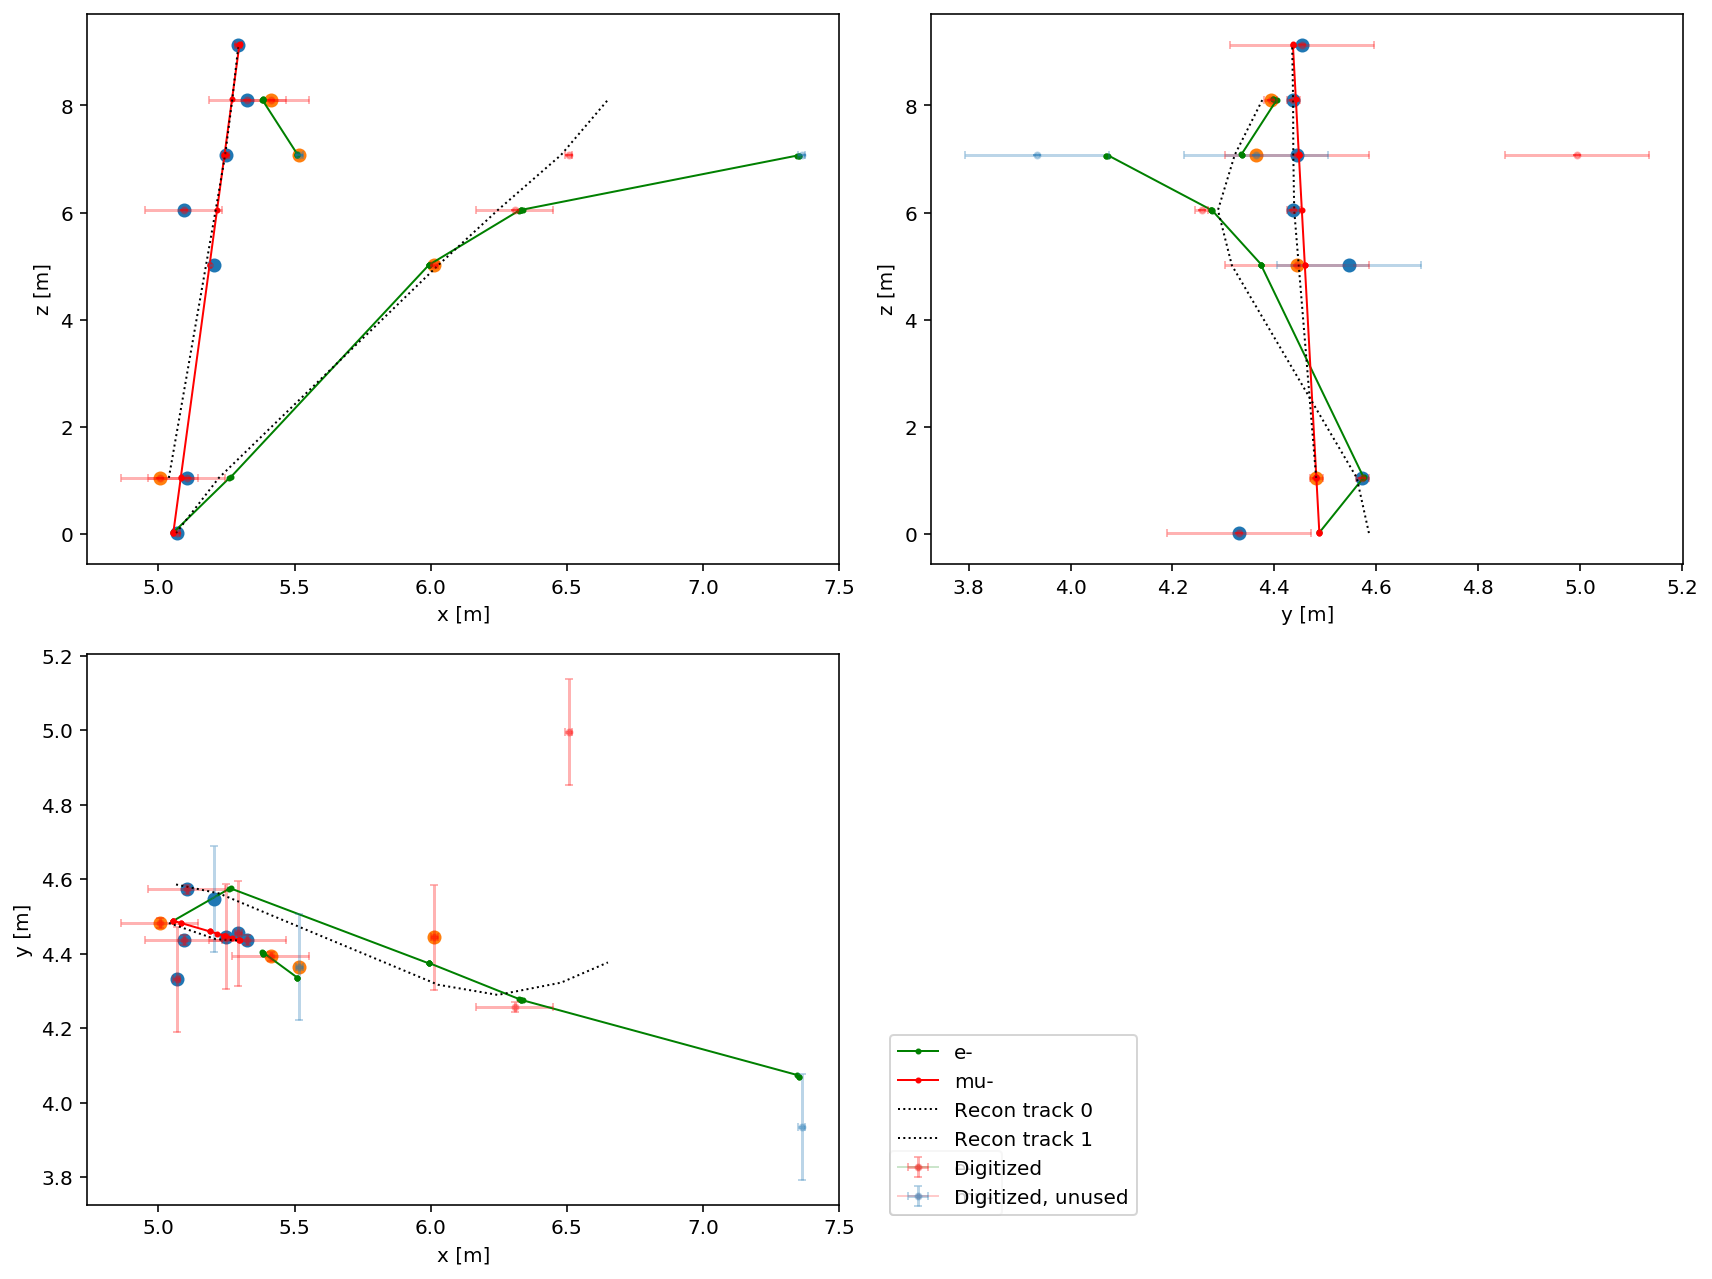

In [29]:
fig,axs=plt.subplots(2,2,figsize=(12,9))
axs=axs.flatten()
fig = vis.plot_truth(ev,fig=fig, disp_det_view=False, disp_vertex=False, disp_first_hit=False);
fig = vis.plot_recon(ev,fig=fig, disp_det_view=False, disp_recon_vertex=False);


for i in range(len(tracks_found)):
    track=tracks_found[i]
    seed=seeds_found[i]
    xyz_track = [[hit_2_temp.x,hit_2_temp.y,hit_2_temp.z] for hit_2_temp in track]
    xyz_seed = [[hit_2_temp.x,hit_2_temp.y,hit_2_temp.z] for hit_2_temp in seed]
    xyz_track = np.array([util.coord_cms2det(xyz) for xyz in xyz_track])
    xyz_seed = np.array([util.coord_cms2det(xyz) for xyz in xyz_seed])
    
    axs[0].scatter(xyz_track[:,0],xyz_track[:,2])
    axs[1].scatter(xyz_track[:,1],xyz_track[:,2])
    axs[2].scatter(xyz_track[:,0],xyz_track[:,1])

    
#     plt.sca(axs[0][0])
#     xyz = util.coord_cms2det(np.array([hit_2_temp.x,hit_2_temp.y,hit_2_temp.z]))
#     plt.scatter(xyz[0],xyz[2])
# #     plt.scatter(hit_2_temp.z,hit_2_temp.y)
#     plt.annotate(f"{chi_plus:.3f}", xy=(xyz[0],xyz[2]))
    
#     plt.sca(axs[0][1])
#     xyz = util.coord_cms2det(np.array([hit_2_temp.x,hit_2_temp.y,hit_2_temp.z]))
#     plt.scatter(xyz[1],xyz[2])
# #     plt.scatter(hit_2_temp.z,hit_2_temp.y)
#     plt.annotate(f"{chi_plus:.3f}", xy=(xyz[1],xyz[2]))    

In [30]:
i_event=inds_1[12]
for i_event in inds_1:
    ev.EventNumber=i_event
    ev.Tree.GetEntry(i_event)
    hits = np.array(get_digi_hits(ev))

    tracks_found = []
    seeds_found = []

    hits_used_mask = np.zeros(len(hits),dtype=bool)
    niter=0
    while (sum(hits_used_mask)<len(hits_used_mask)):
    #     print(hits_used_mask)
        seeds, seeds01_idx =  seed_bilayer(hits, hits_used_mask)
    #     print(seeds01_idx)
        ALL_SEEDS_FAILED = True
        for i in range(len(seeds)):
            seed = seeds[i]
            seed0_idx = seeds01_idx[i][0]
            u_kf_find = kf_find(seed,hits,seed0_idx, hits_used_mask=hits_used_mask, chi2_add=10)
            # If a seed gives successful result, mask those hits
            #  - and break from the loop. Renew the seeds and come back
            if(u_kf_find.find_all()):
                hits_used_mask[u_kf_find.FOUND_HITS_IDX] = True
                ALL_SEEDS_FAILED = False
                # Store the found track
                if niter==0:
                    print(u_kf_find.FOUND_HITS_IDX,"\n")
                tracks_found.append(hits[u_kf_find.FOUND_HITS_IDX])
                seeds_found.append(hits[seeds01_idx[i]])
                break

        # End the while loop if all seeds failed
        if ALL_SEEDS_FAILED:
            break

        # End the while loop if too many iterations
        niter+=1
        if niter>20:
            break

#     print(tracks_found[0])

chi+ 5.701326111088862
chi+ 2.147860033743153
chi+ 1.4155501417439202
chi+ 3.8861910162038025
chi+ 0.8875776726853659
chi+ 1.3733214133734952
2.1729518787831523
5.537260524015599
1.047046938856628
4.1651744214957205
12.534599916341254
7.643601402839302
[0, 1, 2, 3, 4, 5, 6] 

chi+ 65.70061476479816
chi+ 83.42552501249976
chi+ 3.179917139009737
chi+ 4.432927541726433
9.269231930300903
161.6974959658835
298.53244128218444
364.65526660450615
chi+ 73.65127154172734
chi+ 69.06387871878924
chi+ 2.4856898141410353
chi+ 3.2255700012257025
8.820590452508537
167.62776900145607
299.7106618908681
305.2803502201659
chi+ 154.4006445147395
chi+ 15.964618663430182
chi+ 3.537731231349637
44.327366417317364
606.2644278637293
381.90171386708795
chi+ 154.4006445147395
chi+ 15.964618663430182
chi+ 3.537731231349637
44.327366417317364
606.2644278637293
381.90171386708795
chi+ 78.78826842692439
chi+ 171.66673042467093
chi+ 272.56893162399996
332.30677776227225
1974.8968118160558
371.9074302871619
chi+ 70.003

KeyboardInterrupt: 

### What about Hough transform?

--Doesn't work. We have too few points with large uncertainty

In [173]:
def hough_line(xs, ys, y_sigmas=None, sigma_steps=5):
    # Rho and Theta ranges
    x0=np.mean(xs)
    y0=np.mean(ys)
    xs=np.array(xs)-x0
    ys=np.array(ys)-y0
    distance_max = np.max([np.sqrt(x**2+y**2) for x,y in zip(xs,ys)])
    # Steps
    theta_steps = 180
    rho_steps = 180
    thetas = np.deg2rad(np.linspace(0, 180.0, theta_steps))
    rhos = np.linspace(-distance_max, distance_max, rho_steps)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((rho_steps, theta_steps))
    
    # Get the weight of each sigma step
    sigmas = np.linspace(-2,2,sigma_steps*2)
    sigma_weight = scipy.stats.norm.cdf(sigmas) 
    sigma_weights = sigma_weight[1:]-sigma_weight[:-1]
    sigma_centers =0.5*(sigmas[1:]+sigmas[:-1])

    # Vote in the hough accumulator
    for i in range(len(xs)):
        x = xs[i]
        y = ys[i]
        for t_idx in range(theta_steps):
            if y_sigmas is None:
                # Calculate rho. rho_steps is added for a positive index
                rho = x * cos_t[t_idx] + y * sin_t[t_idx]
                rho_idx = np.argmax(rhos>rho)
                accumulator[rho_idx, t_idx] += 1
            else:
                for j in range(len(sigma_centers)):
                    delta_y = y_sigmas[i]*sigma_centers[j]
                    rho = x * cos_t[t_idx] + (y+delta_y) * sin_t[t_idx]
                    rho_idx = np.argmax(rhos>rho)
                    accumulator[rho_idx, t_idx] += sigma_weights[j]                  
                
    return accumulator, thetas, rhos

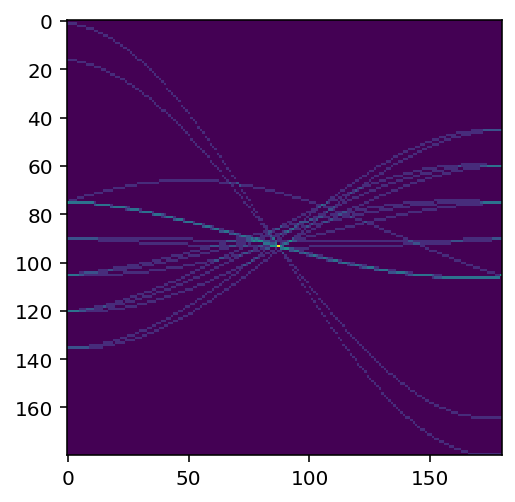

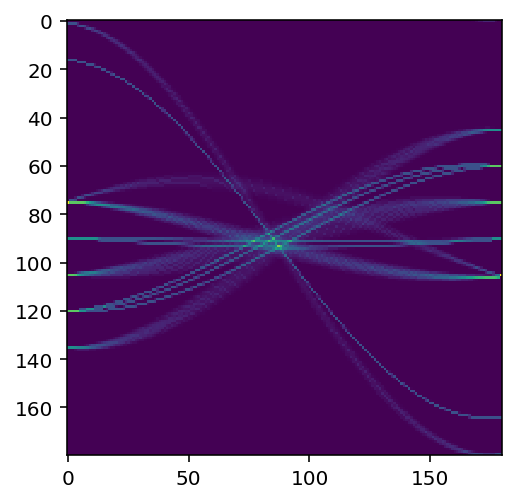

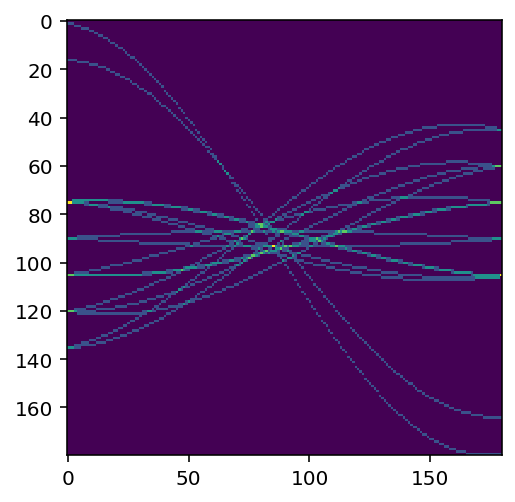

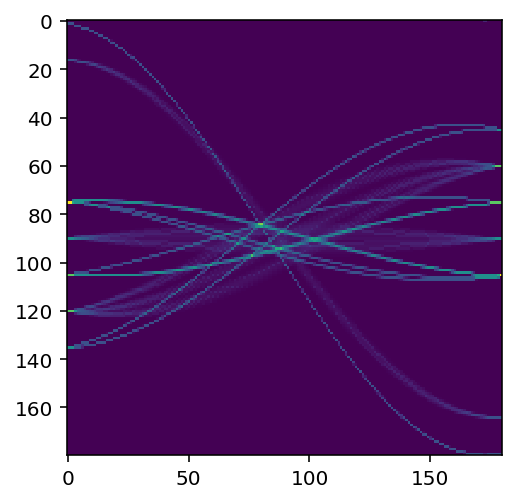

In [174]:
xs = [hit.y for hit in hits]
ys = [hit.x for hit in hits]
accumulator, thetas, rhos =  hough_line(xs, ys)
plt.imshow(accumulator)
plt.show()

y_error = [hit.x_uncertainty for hit in hits]
accumulator2, thetas, rhos =  hough_line(xs, ys, y_sigmas=y_error)
plt.imshow(accumulator2)
plt.show()



xs = [hit.y for hit in hits]
ys = [hit.z for hit in hits]
accumulator, thetas, rhos =  hough_line(xs, ys)
plt.imshow(accumulator)
plt.show()

y_error = [hit.z_uncertainty for hit in hits]
accumulator2, thetas, rhos =  hough_line(xs, ys, y_sigmas=y_error)
plt.imshow(accumulator2)
plt.show()

---

In [35]:
filename=f"{file_prefix}/stat_seedmod.root"
tree_name="integral_tree"
ev = event.Event(filename, 0, tree_name=tree_name)
nevents = int(ev.Tree.GetEntries())
cut=cutflow.sample_space("")



# for i_event in tqdm(range(nevents)):
nfailed_seeding=0
seeds_all=[]
seeds_perevent=[]
for i_event in tqdm(range(nevents)):
    ev.EventNumber=i_event
    ev.Tree.GetEntry(i_event)
    hits = get_digi_hits(ev)
    
    seeds=Seed(hits,cut=5)
    seeds_all.append(seeds)
    seeds_nc=Seed(hits,cut=None)
    seeds_perevent.append(seeds_nc)    
    if len(seeds)==0:
        nfailed_seeding+=1
print(nfailed_seeding,nevents)
sees_all=np.array(sees_all)

100%|██████████| 40000/40000 [00:19<00:00, 2100.02it/s]


369 40000


At |ds|<5
 Event with 0 seeds 369.0 out of 40000
At |ds|<7
 Event with 0 seeds 50.0 out of 40000


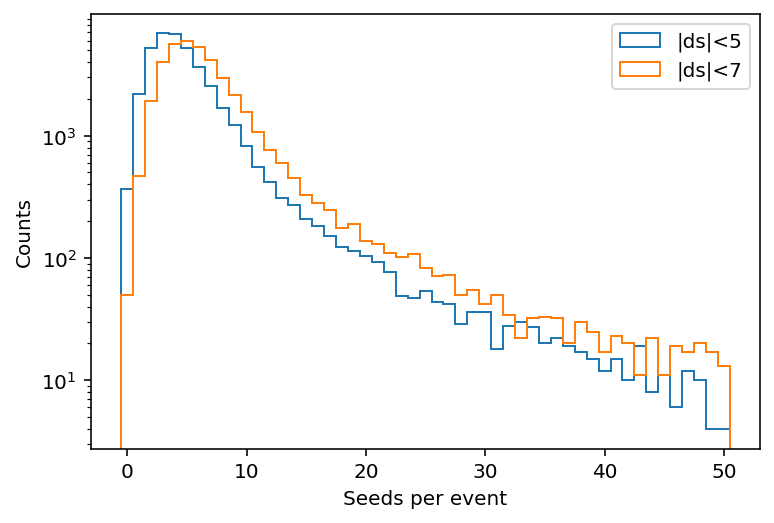

In [56]:
seed_per_event=[]
seed_per_event_cut6=[]

for seeds in seeds_all:
    seed_per_event.append(len(seeds))
for seeds in seeds_perevent:
    n=0
    for seed in seeds:
        if seed[-1]<7:
            n+=1
    seed_per_event_cut6.append(n)
n,ibins,p=plt.hist(seed_per_event,bins=np.linspace(-0.5,50.5,52),log=1,histtype="step",label="|ds|<5");
n2,ibins,p=plt.hist(seed_per_event_cut6,bins=np.linspace(-0.5,50.5,52),log=1,histtype="step",label="|ds|<7");
plt.xlabel("Seeds per event")
plt.ylabel("Counts")
plt.legend()
print("At |ds|<5")
print(" Event with 0 seeds",n[0],"out of",len(seed_per_event))
print("At |ds|<7")
print(" Event with 0 seeds",n2[0],"out of",len(seed_per_event))

In [43]:
369, (1-0.9885)*40000

(369, 459.9999999999982)

---
### Backup, read one file

In [185]:
# 1. filename
muon_energy = 100 #GeV
data_dir    = "/project/def-mdiamond/tomren/mathusla/data/fit_study"
files=glob.glob(f"{data_dir}/muon_{muon_energy}_GeV/*/*/stat*.root",)
files=util.Utils.sortByExt(files)
filename = files[-1]
# filename='../../simdata/fit_study/run0.root'
# print(files)
print(filename,"\n")

# 2. Open one file and print branches
tfile = root.TFile.Open(filename)
tree_name = ["integral_tree","box_run"][0]
Tree = tfile.Get(tree_name)

barnches = Tree.GetListOfBranches()
nevents = int(Tree.GetEntries())
branch_list = [barnches[i].GetName() for i in range(len(barnches))]
print(branch_list)

/project/def-mdiamond/tomren/mathusla/data/fit_study/muon_100_GeV/20230129/191525/stat200.root 

['NumHits', 'Hit_energy', 'Hit_time', 'Hit_detId', 'Hit_particlePdgId', 'Hit_G4TrackId', 'Hit_G4ParentTrackId', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_particleEnergy', 'Hit_particlePx', 'Hit_particlePy', 'Hit_particlePz', 'Digi_numHits', 'Digi_time', 'Digi_x', 'Digi_y', 'Digi_z', 'Digi_energy', 'Digi_px', 'Digi_py', 'Digi_pz', 'Digi_particle_energy', 'Digi_pdg_id', 'Digi_seed', 'GenParticle_index', 'GenParticle_G4index', 'GenParticle_pdgid', 'GenParticle_time', 'GenParticle_x', 'GenParticle_y', 'GenParticle_z', 'GenParticle_energy', 'GenParticle_px', 'GenParticle_py', 'GenParticle_pz', 'GenParticle_mass', 'EXTRA_12', 'EXTRA_13', 'EXTRA_14', 'EXTRA_15', 'Vertex_k_m_t', 'Vertex_k_m_x', 'Vertex_k_m_y', 'Vertex_k_m_z', 'Vertex_k_m_ErrorT', 'Vertex_k_m_ErrorX', 'Vertex_k_m_ErrorY', 'Vertex_k_m_ErrorZ', 'vertex_k_m_chi2', 'Vertex_k_m_trackIndices', 'NumVertices_k_m', 'Track_k_m_velX', 'Track_k_m_velY', 

## Plot multiple truth tracks

(-1.0, 11.0)

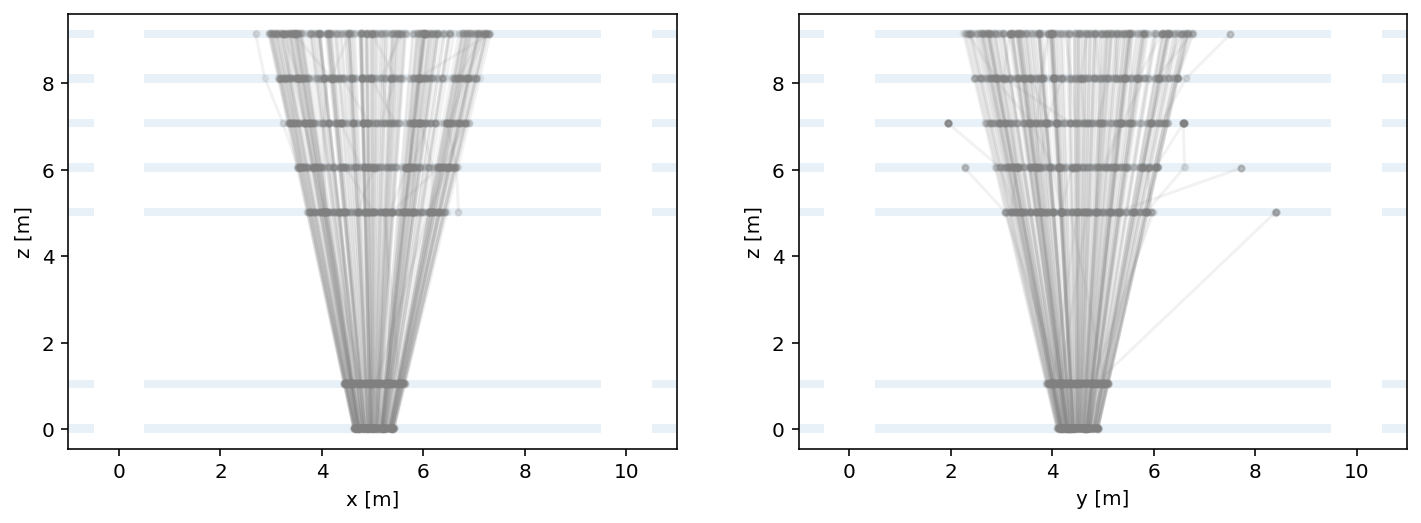

In [9]:
ev = event.Event(filename, 0, tree_name=tree_name)

fig,axs=plt.subplots(1,2,figsize=(12,4))
xlabels=["x [m]", "y [m]"]

for i in range(nevents):
# for i in [8,9]:
#     ev = event.Event(filename, i, tree_name=tree_name)
    ev.EventNumber=i

    tracks=ev.get_truthtrack()
    if len(tracks)>0:
        for track in tracks:
            track=util.coord_cms2det(track)
            axs[0].plot(track[0],track[2],marker=".",color="grey",alpha=0.1)
            axs[1].plot(track[1],track[2],marker=".",color="grey",alpha=0.1)    
    
vis.drawdet_xz(axis=axs[0])
vis.drawdet_xz(axis=axs[1])

axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('z [m]')
axs[1].set_xlabel('y [m]')
axs[1].set_ylabel('z [m]')
axs[0].set_xlim(-1,11)
axs[1].set_xlim(-1,11)

## Plot one track with its Kalman filter reconstruction

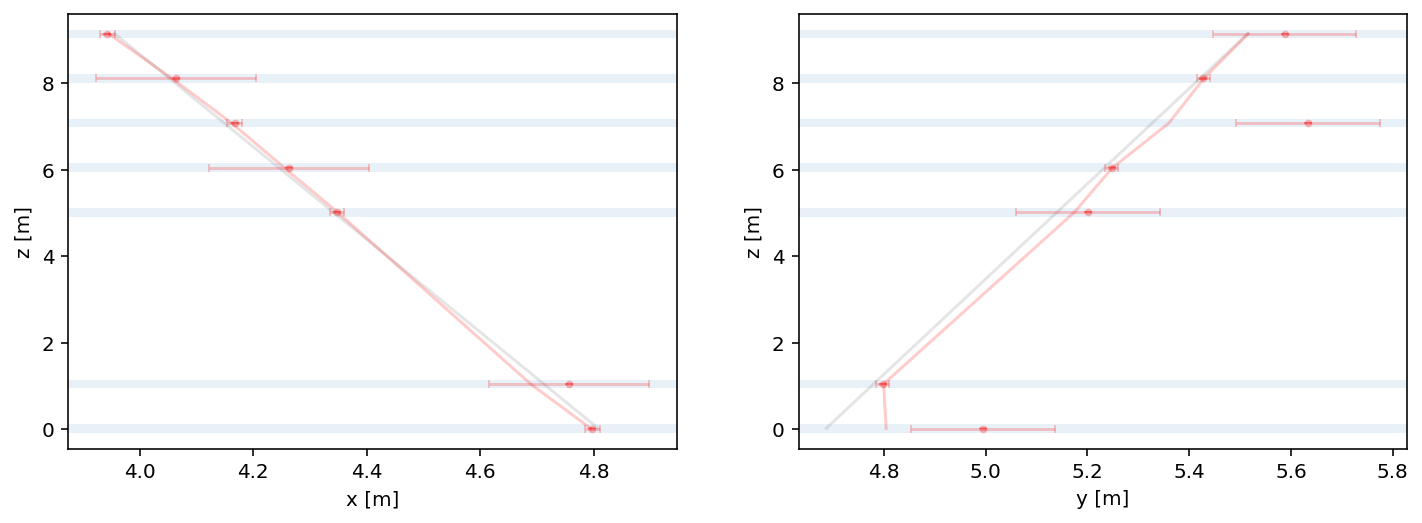

In [186]:
ev = event.Event(filename, 0, tree_name=tree_name)
ev.EventNumber=6
cut=cutflow.sample_space("")

# Get the "truth" tracks, the "digitized" tracks, and the reconstrunction
truthtracks=ev.get_truthtrack()
event_vis = ev.get_recon_kalman()

# Plot x-z, y-z separately
fig,axs=plt.subplots(1,2,figsize=(12,4))
xlabels=["x [m]", "y [m]"]
for i_axis in [0,1]:
    # Plot truth tracks
    if len(truthtracks)>0:
        for track in truthtracks:
            track=util.coord_cms2det(track)
            axs[i_axis].plot(track[i_axis],track[2],color="grey",alpha=0.2)

    # Plot reconstructed tracks
    for i_track in range(len(event_vis["track_nonvertex"])):
        # Read the reconstructed track
        track=event_vis["track_nonvertex"][i_track]
        track=util.coord_cms2det(np.array(track))
        hits=[[],[],[]]
        hits_uncertainty=[[],[],[]]
        
        # Read hits of this track
        for i_hit in range(len(track[0])):
            hit=event_vis["hit_nonvertex"][i_track][i_hit]
            hit_layer = cut.in_layer(hit[1])
            hit_uncertainty = np.array(detector.Layer().uncertainty(hit_layer))
            hit=util.coord_cms2det(np.array(hit))
            hit_uncertainty=hit_uncertainty[[2,0,1]]
            for i in range(3):
                hits[i].append(hit[i])
                hits_uncertainty[i].append(hit_uncertainty[i])
        # Plot track and hits
        axs[i_axis].errorbar(hits[i_axis],hits[2],
                             xerr=hits_uncertainty[i_axis],yerr=hits_uncertainty[2],
                             color="red",capsize=2,ls='none',alpha=0.2, fmt=".")
        axs[i_axis].plot(track[i_axis],track[2],color="red",alpha=0.2)
        

    axs[i_axis].set_xlabel(xlabels[i_axis])
    axs[i_axis].set_ylabel('z [m]')
    vis.drawdet_xz(axis=axs[i_axis])


In [29]:
# 'Tree.GetEntry(1)
# print(Tree.Track_k_m_x0), print(Tree.Hit_x[0]),print(Tree.Track_k_m_y0), print(Tree.Hit_y[0]),Track_k_m_velY', 'Track_k_m_velZ', 'Track_k_m_x0','

In [86]:
truth=[]
recon=[]
Entry=1

n_events=0
n_failed=0
# list_failed=[]

for i,filename in enumerate(tqdm(files)):
    tfile = root.TFile.Open(filename)
    tree_name = ["integral_tree","box_run"][0]
    Tree = tfile.Get(tree_name)
    
    for Entry in range(100):
        Tree.GetEntry(Entry)
        try:
            n_events+=1
            recon.append([Tree.Track_k_m_z0[0], Tree.Track_k_m_x0[0], Tree.Track_k_m_y0[0], Tree.Track_k_m_t0[0]])
            truth.append([Tree.Hit_z[0], Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_time[0]])
        except:
            n_failed+=1
        #list_failed.append(i)

  0%|          | 0/200 [00:00<?, ?it/s]

In [87]:
n_failed/n_events

0.1803

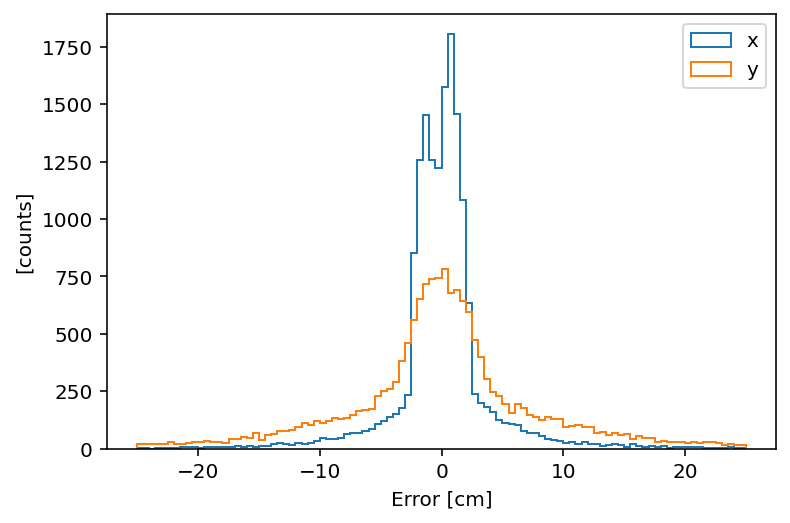

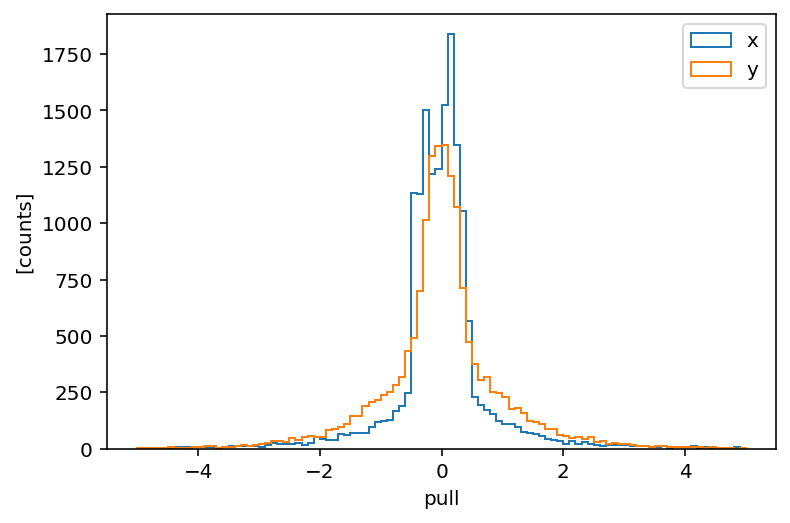

In [97]:
recon=np.array(recon)
truth=np.array(truth)
def pull(x):
    return (x-np.mean(x))/np.std(x)
plt.hist(recon[:,0]-truth[:,0],bins=100,range=(-25,25),histtype="step",label="x0");
plt.hist(recon[:,1]-truth[:,1],bins=100,range=(-25,25),histtype="step",label="y0");

plt.xlabel("Error [cm]")
plt.ylabel("[counts]")
plt.legend()
plt.show()

plt.hist(pull(recon[:,0]-truth[:,0]),bins=100,range=(-5,5),histtype="step",label="x0");
plt.hist(pull(recon[:,1]-truth[:,1]),bins=100,range=(-5,5),histtype="step",label="y0");

plt.xlabel("pull")
plt.ylabel("[counts]")
plt.legend()

In [ ]:
# /gen/pythia/process {process}

# /gen/pythia/cuts/clear
# /gen/pythia/cuts/add 13 | | 0.6:1.9 | -0.695:0.695 rad
# /gen/pythia/cuts/add 14 | | 0.6:1.9 | -0.695:0.695 rad